In [1]:
import os
import time

import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
if not os.path.exists('./ae_mnist'):
    os.mkdir('./ae_mnist')

In [3]:
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor

def tensor_round(tensor):
    return torch.round(tensor)

def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [4]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
    transforms.Lambda(lambda tensor:tensor_round(tensor))
])

In [5]:
dataset = MNIST('', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [21]:
for data in dataloader:
    break;
data[0].shape[0]

128

Label: 3


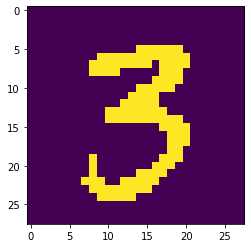

In [7]:
i = 30
plt.imshow(data[0][i].view((28, 28)))
print(f'Label: {data[1][i]}')

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('running on the GPU')
else:
    device = torch.device('cpu')
    print('running on the CPU')

running on the GPU


In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True)
        )

        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))
        
model = AutoEncoder().to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)


In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3, weight_decay=1e-5)

In [11]:
# len(dataloader)

In [12]:
# size = 1
# random_start = np.random.randint(len(dataset)-size)
# print(random_start)
# random_range = range(random_start, random_start+size)
# random_batch = torch.utils.data.Subset(dataset, random_range)
# random_loader = DataLoader(random_batch, batch_size=1, num_workers=1)
# for data in random_loader:
#     break
# img, _ = data
# img.shape

In [13]:
# def fwd_pass(img, train=False):
#     outputs = model(img)
#     BCE_loss = criterion(outputs, img)
#     MSE_loss = nn.MSELoss()(outputs, img)
    
#     if train:
#         model.zero_grad()
#         BCE_loss.backward()
#         optimizer.step()
    
#     return BCE_loss, MSE_loss

# def test(size=128):
#     random_start = np.random.randint(len(dataset)-size)
#     random_range = range(random_start, random_start+size)
#     random_batch = torch.utils.data.Subset(dataset, random_range)
#     random_loader = DataLoader(random_batch, batch_size=128, num_workers=1)
#     for data in random_loader:
#         break
#     img, _ = data
#     with torch.no_grad():
#         val_BCEloss, val_MSEloss = fwd_pass(img.to(device))
    
#     return val_BCEloss, val_MSEloss

In [30]:
MODEL_NAME = f'model-{int(time.time())}'
print(MODEL_NAME)
num_epochs = 100

for epoch in range(num_epochs):
#         i = 0
    with open(f'ae_mnist_{MODEL_NAME}.log', 'a') as f:
        for data in tqdm(dataloader, position=0, leave=True):
            img, _ = data
            img = img.view(img.size(0), -1)
            img = Variable(img).to(device)
            # ===================forward=====================
            output = model(img)
            loss = criterion(output, img)
            MSE_loss = nn.MSELoss()(output, img)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    #             BCE_loss, MSE_loss = fwd_pass(img, train=True)
    #             if i % 5 == 0:
    #                 val_BCEloss, val_MSEloss = test()
    #                 f.write(f'{MODEL_NAME},{round(time.time(), 3)},'\
    #                         f'{round(float(BCE_loss), 4)},{round(float(MSE_loss), 4)},'\
    #                         f'{round(float(val_BCEloss), 4)},{round(float(val_MSEloss), 4)}\n')
        # ===================log========================
        
        print(f'epoch [{epoch+1}/{num_epochs}], '\
              f'loss:{loss.data.item():.4f}, MSE_loss:{MSE_loss.data.item():.4f}')
        f.write(f'{epoch+1},{round(time.time(), 3)},'\
                f'{loss.data.item():.4f},{MSE_loss.data.item():.4f}\n')
    if epoch % 5 == 0:
        x = to_img(img.cpu().data)
        x_hat = to_img(output.cpu().data)
        save_image(x, f'./ae_mnist/x_{epoch}.png')
        save_image(x_hat, f'./ae_mnist/x_hat_{epoch}.png')
        
torch.save(model.state_dict(), f'./ae_minist_{MODEL_NAME}_statedict.pth')

  1%|          | 4/469 [00:00<00:12, 37.37it/s]

model-1595575843


100%|██████████| 469/469 [00:09<00:00, 51.35it/s]

  1%|          | 5/469 [00:00<00:10, 42.96it/s]

epoch [1/100], loss:0.0471, MSE_loss:0.0137
torch.Size([96, 1, 28, 28])


 39%|███▉      | 184/469 [00:03<00:05, 49.62it/s]

KeyboardInterrupt: 

 39%|███▉      | 184/469 [00:18<00:05, 49.62it/s]

In [22]:
for data in dataloader:
    break
img, _ = data
img = img.view(img.size(0), -1)
img = Variable(img).to(device)
x = to_img(img.cpu().data)
x.shape[0]
# for i in tqdm(range(img.size(0))):
#     save_image(img[i,:,:,:], f'test{i}.png')
# save_image(img, 'test_save_batch.png')

128